In [1]:
import datetime
import os
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

from IPython.display import Markdown

# from matplotlib import style
import seaborn as sns
%matplotlib inline

# API settings and information import
from env import *
from nomics import Nomics
nomics = Nomics(key=api_key)

# Custom function import
from anomaly_functions import *

## Pull in the last 1000 days of BTC price on a daily basis

In [2]:
end = datetime.datetime.now(datetime.timezone.utc).isoformat()
start = (datetime.datetime.now(datetime.timezone.utc)
         - datetime.timedelta(days=1000)).isoformat()
daily_btc_df = pd.DataFrame(nomics.ExchangeRates.get_history(
currency='BTC',
start=start,
end=end))
daily_btc_df['date'] = pd.to_datetime(daily_btc_df.timestamp)
daily_btc_df = daily_btc_df.set_index(daily_btc_df.date).drop(columns=['date','timestamp'])

### Look at the BTC price on a daily basis for the last 1000 days

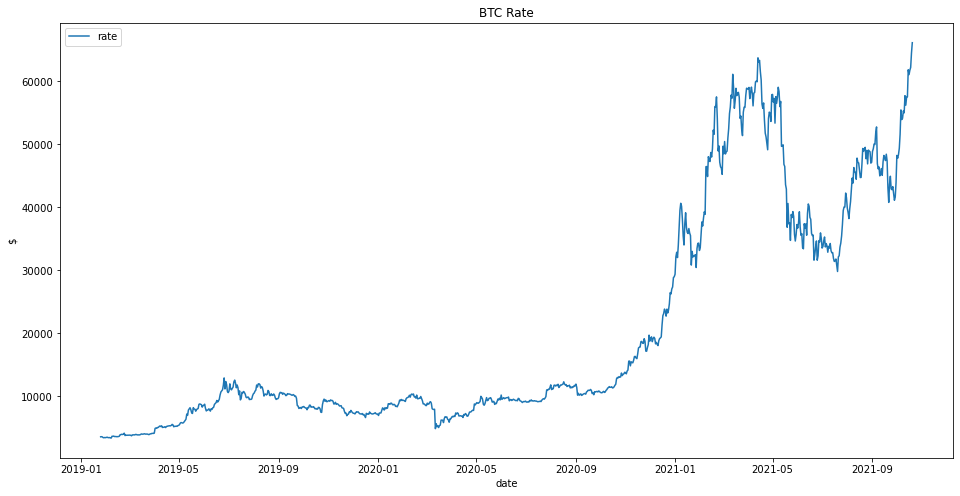

In [3]:
daily_btc_df.rate = pd.to_numeric(daily_btc_df.rate)
plt.figure(figsize=(16,8))
sns.lineplot(data=daily_btc_df).set(title = 'BTC Rate')
plt.ylabel('$')
plt.show()

In [4]:
daily_btc_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1000 entries, 2019-01-25 00:00:00+00:00 to 2021-10-20 00:00:00+00:00
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   rate    1000 non-null   float64
dtypes: float64(1)
memory usage: 15.6 KB


### Take a look at the Exponentional Moving Averages at various intervals

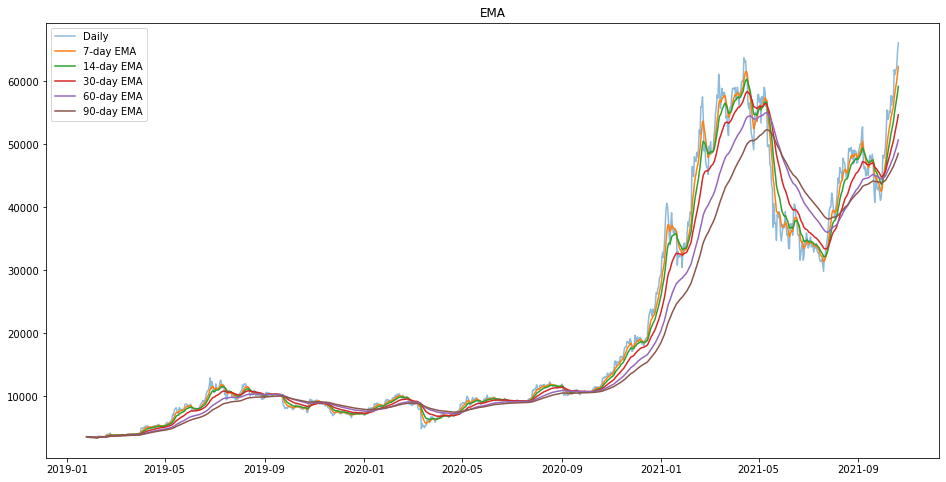

In [5]:
generateEMA(daily_btc_df)

### Bollinger Bands and %b

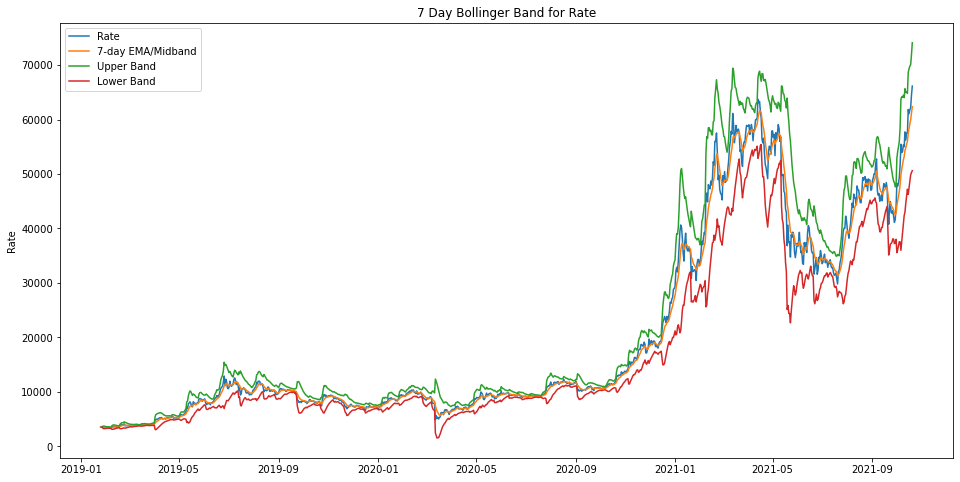

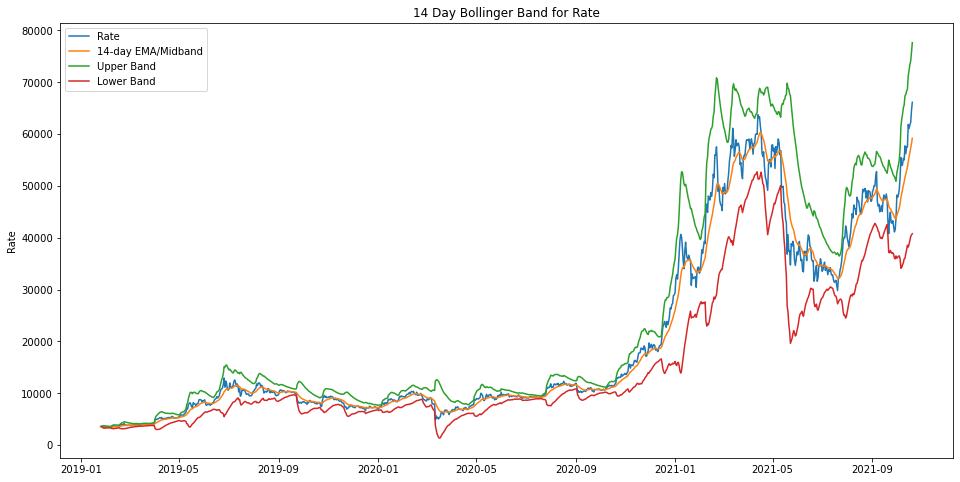

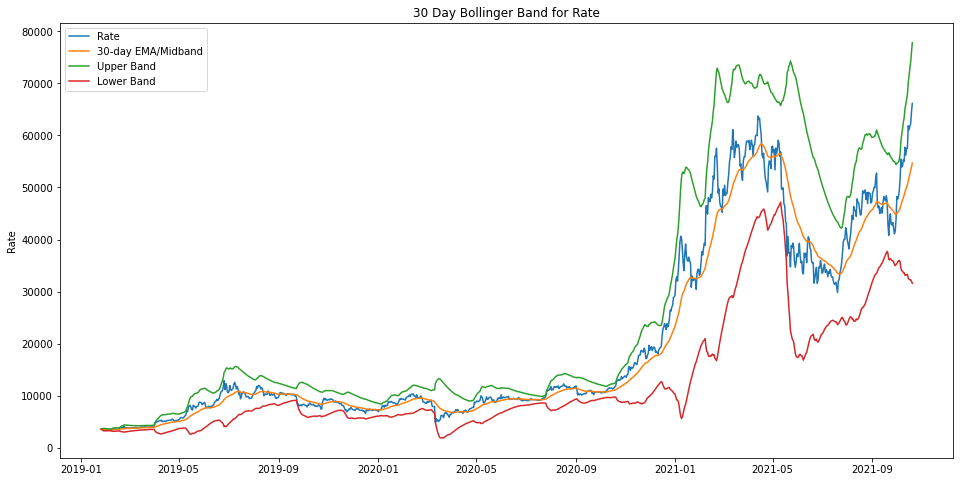

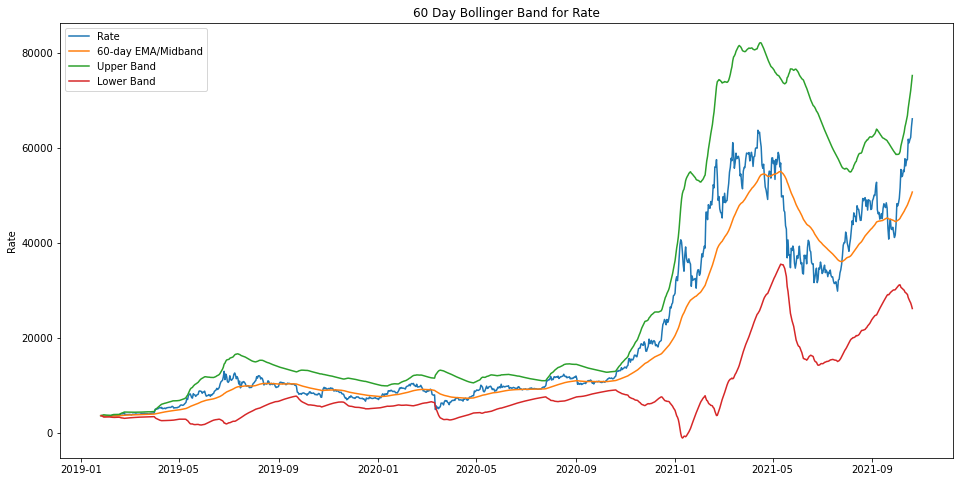

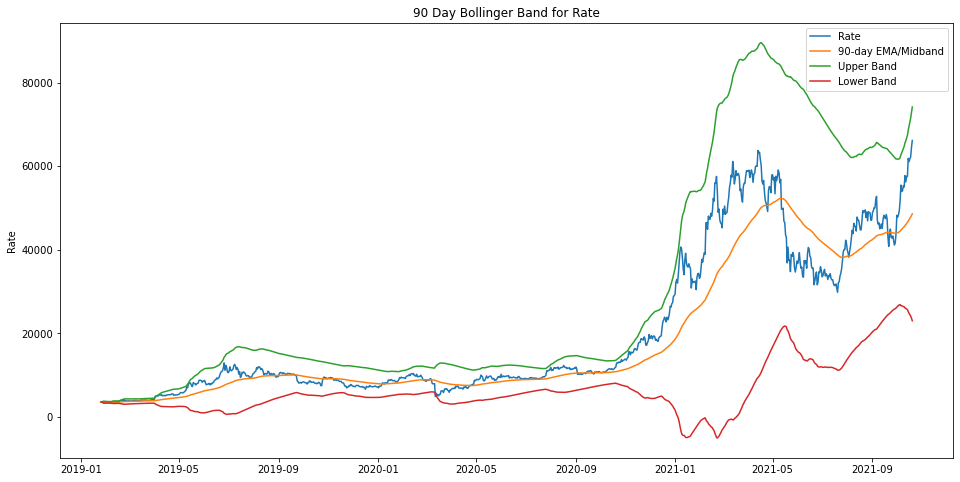

In [6]:
bb_df_list, result = generateBollingerBands(daily_btc_df, k=3)

In [10]:
bb_df_list['30_day']

,rate,midband,upper_band,lower_band,pct_b
date,,,,,
2019-01-25 00:00:00+00:00,3571.207611,3571.207611,NaN,NaN,NaN
2019-01-26 00:00:00+00:00,3587.777030,3579.768478,3614.917523,3544.619432,0.613923
2019-01-27 00:00:00+00:00,3558.589451,3572.233104,3616.810347,3527.655861,0.346966
2019-01-28 00:00:00+00:00,3447.220034,3537.787447,3734.727442,3340.847453,0.270063
2019-01-29 00:00:00+00:00,3415.996201,3510.076990,3749.853540,3270.300440,0.303816
...,...,...,...,...,...
2021-10-16 00:00:00+00:00,61072.423288,51927.822782,71454.111277,32401.534287,0.734161
2021-10-17 00:00:00+00:00,61768.055220,52562.676488,72837.976491,32287.376484,0.727010
2021-10-18 00:00:00+00:00,62207.851959,53184.945873,74085.677622,32284.214123,0.715851
